In [1]:
import pandas as pd
import numpy as np
from yahooquery import Ticker
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

In [2]:
tickers = {
    "JPM": "Banking", "BAC": "Banking",
    "JNJ": "Healthcare", "PFE": "Healthcare",
    "DIS": "Entertainment", "NFLX": "Entertainment",
    "AAPL": "Technology", "MSFT": "Technology",
    "CVX": "Energy", "ENB": "Energy"
}

In [3]:
start_date = "2000-01-01"
end_date = "2024-12-31"

In [4]:
t = Ticker(list(tickers.keys()))
hist = t.history(start=start_date, end=end_date)

In [5]:
hist = hist.reset_index().rename(columns={"symbol": "Ticker"})

In [6]:
hist["Return"] = hist.groupby("Ticker")["adjclose"].pct_change()

In [7]:
stats = []

for ticker in tickers.keys():
    df = hist[hist["Ticker"] == ticker].copy()
    rets = df["Return"].dropna()

    stats.append({
        "Ticker": ticker,
        "Sector": tickers[ticker],
        "Mean Return": rets.mean(),
        "Median Return": rets.median(),
        "Volatility (Std Dev)": rets.std(),
        "Skewness": skew(rets),
        "Kurtosis": kurtosis(rets),
        "Min Return": rets.min(),
        "Max Return": rets.max(),
        "Autocorr (Lag 1)": rets.autocorr(1),
        "Observations": len(rets)
    })

stats_df = pd.DataFrame(stats)

In [8]:
stats_df

,Ticker,Sector,Mean Return,Median Return,Volatility (Std Dev),Skewness,Kurtosis,Min Return,Max Return,Autocorr (Lag 1),Observations
0,JPM,Banking,0.000644,0.000329,0.023552,0.810282,15.715140,-0.207274,0.250966,-0.085710,6287
1,BAC,Banking,0.000575,0.000300,0.027576,0.868553,27.596145,-0.289694,0.352691,-0.013442,6287
2,JNJ,Healthcare,0.000356,0.000283,0.012043,-0.177675,12.577740,-0.158456,0.122292,-0.030662,6287
3,PFE,Healthcare,0.000245,0.000000,0.015853,0.033620,4.949978,-0.111456,0.108552,-0.031621,6287
4,DIS,Entertainment,0.000436,0.000290,0.019266,0.288492,9.421896,-0.183630,0.159722,-0.044124,6287
5,NFLX,Entertainment,0.001781,0.000372,0.034935,0.128769,18.968453,-0.409064,0.422235,0.027741,5689
6,AAPL,Technology,0.001217,0.000947,0.024404,-1.469061,36.624432,-0.518692,0.139050,-0.041134,6287
7,MSFT,Technology,0.000574,0.000380,0.019033,0.162197,9.561112,-0.155978,0.195653,-0.075965,6287
8,CVX,Energy,0.000493,0.000776,0.017346,0.109904,19.201133,-0.221248,0.227407,-0.083598,6287
9,ENB,Energy,0.000648,0.000493,0.015865,0.028516,13.776018,-0.178327,0.191448,-0.062152,6287


In [9]:
sector_stats = (
    stats_df.groupby("Sector")
    .agg({
        "Mean Return": "mean",
        "Volatility (Std Dev)": "mean",
        "Skewness": "mean",
        "Kurtosis": "mean",
        "Autocorr (Lag 1)": "mean"
    })
)

In [10]:
sector_stats

,Mean Return,Volatility (Std Dev),Skewness,Kurtosis,Autocorr (Lag 1)
Sector,,,,,
Banking,0.000610,0.025564,0.839418,21.655642,-0.049576
Energy,0.000571,0.016605,0.069210,16.488576,-0.072875
Entertainment,0.001109,0.027101,0.208630,14.195174,-0.008191
Healthcare,0.000300,0.013948,-0.072027,8.763859,-0.031142
Technology,0.000896,0.021718,-0.653432,23.092772,-0.058550


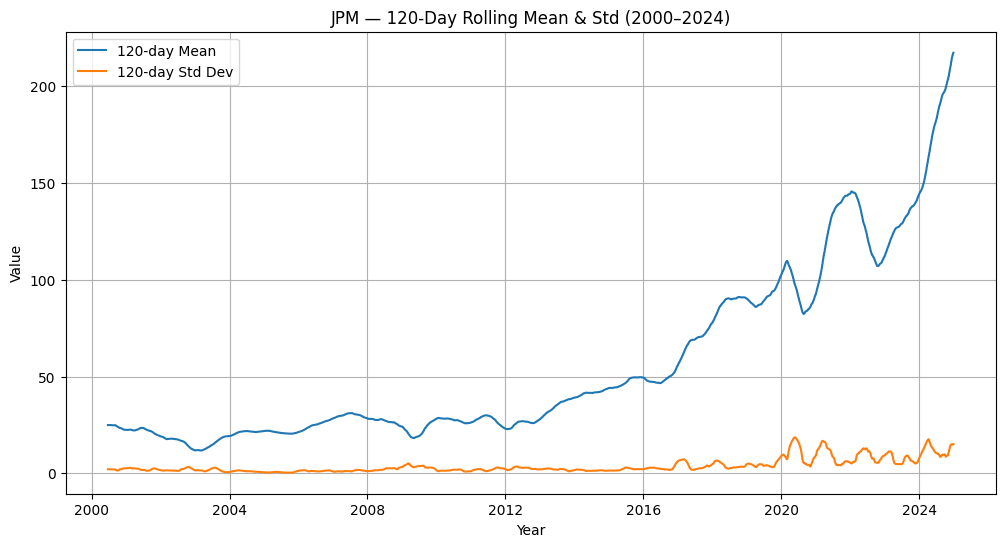

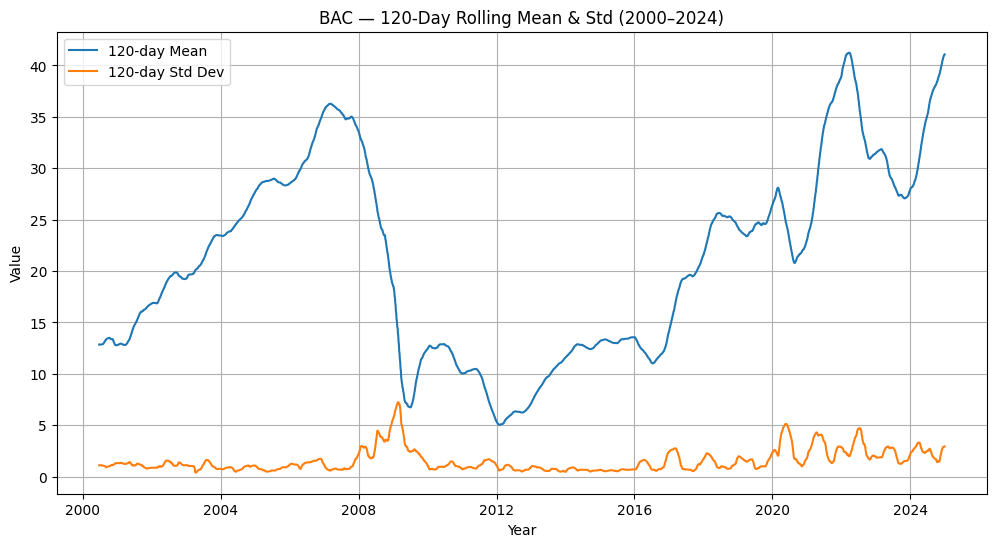

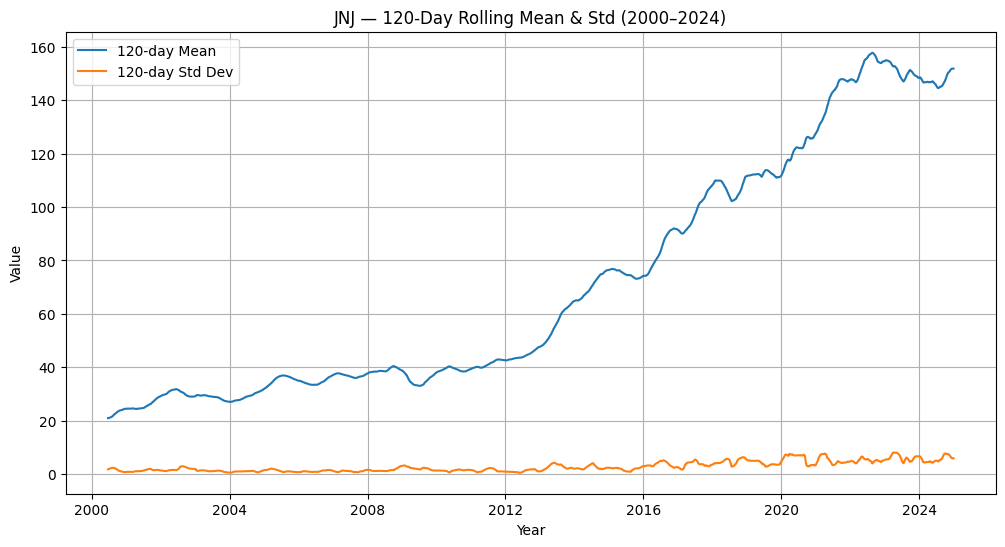

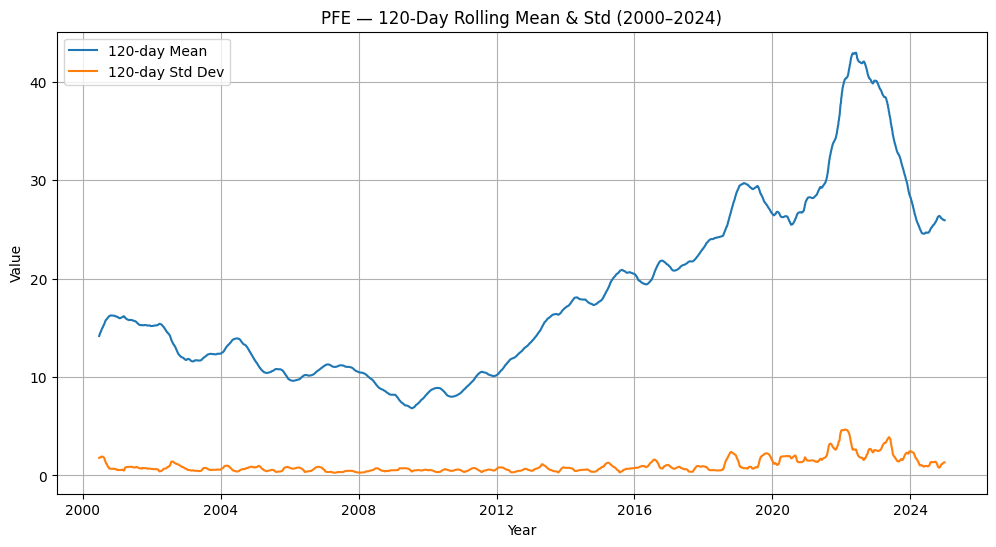

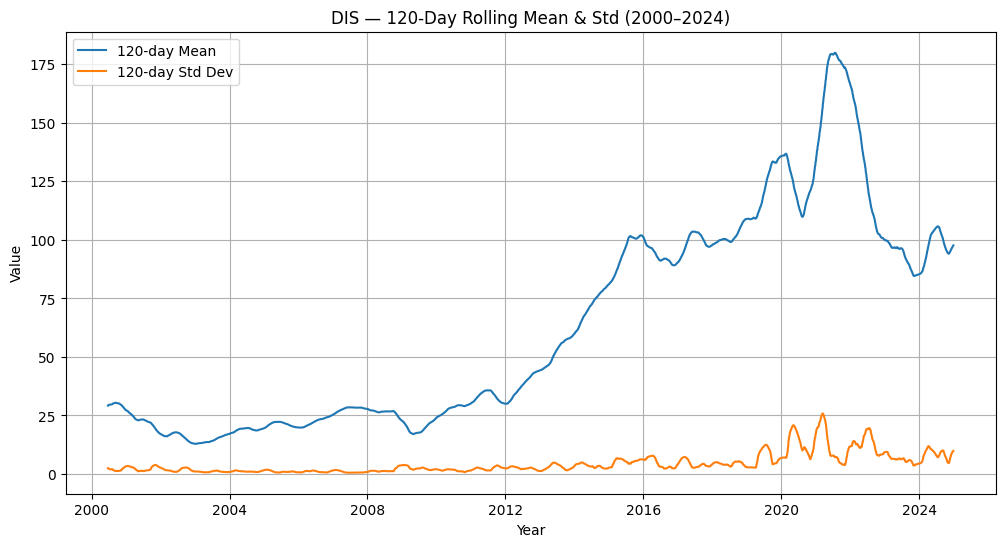

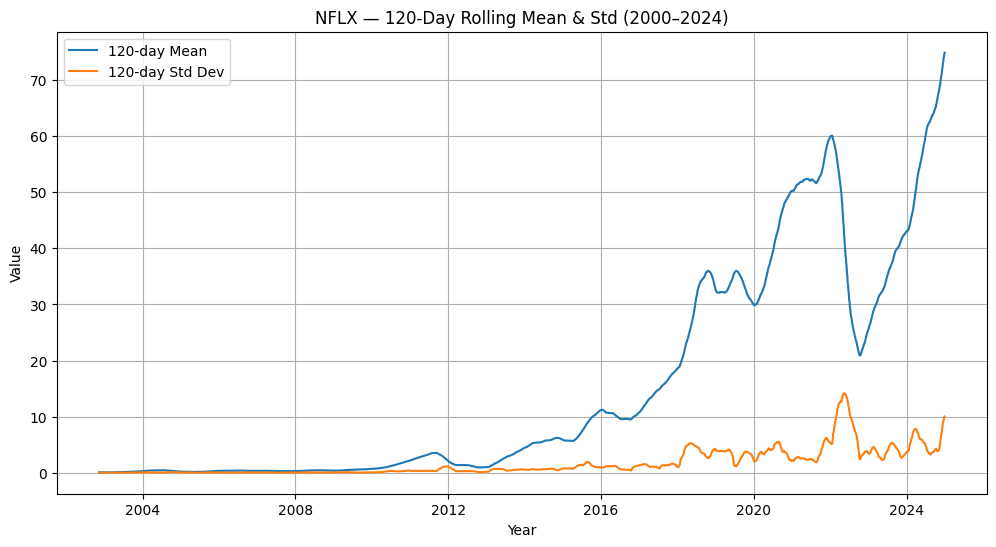

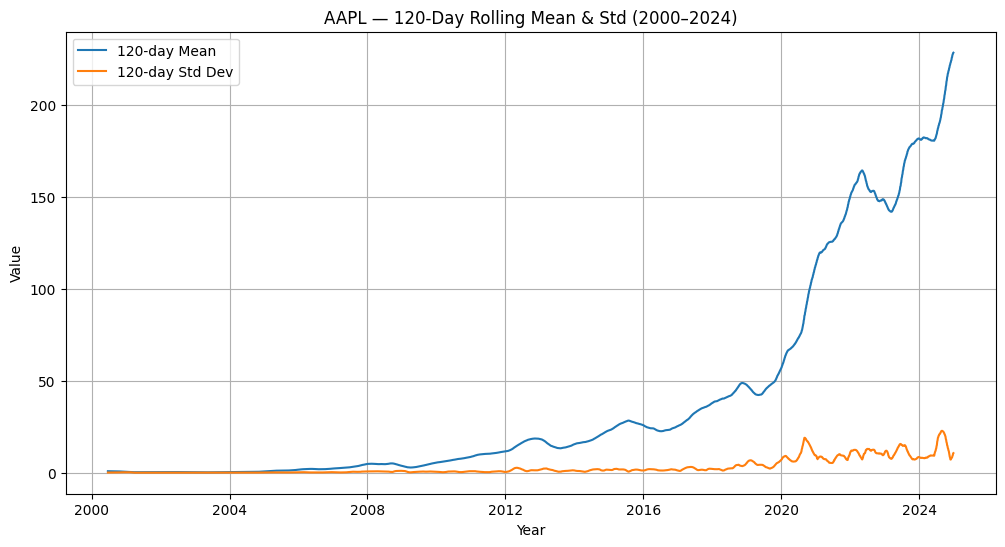

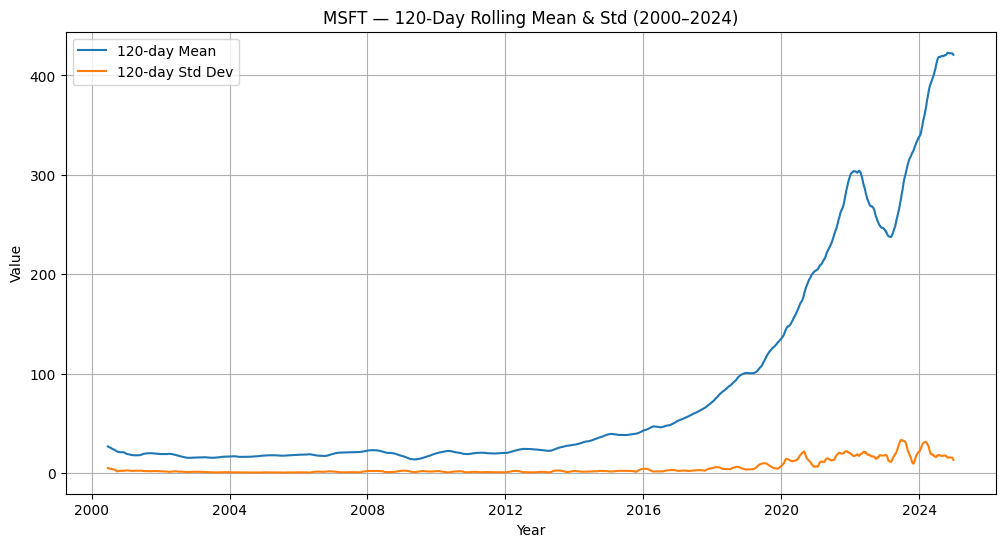

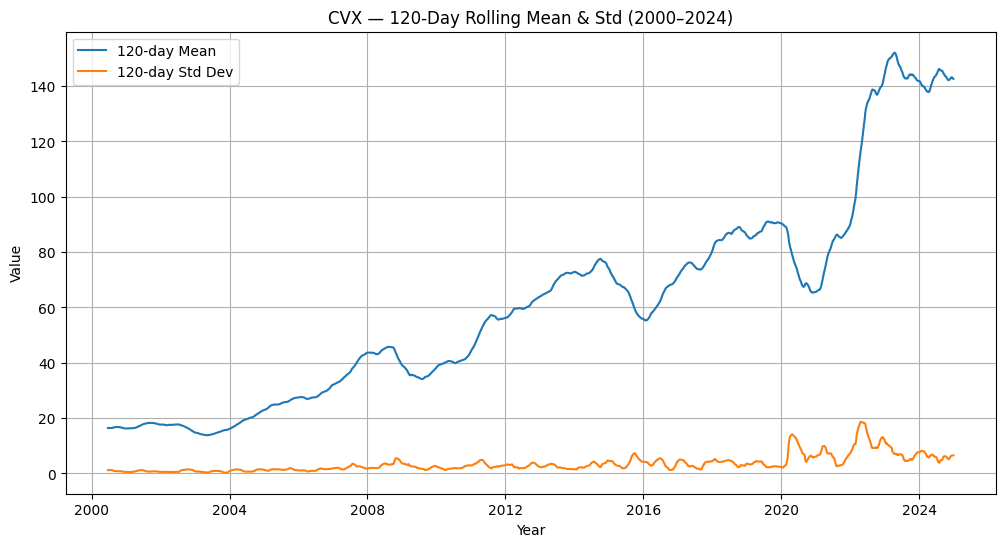

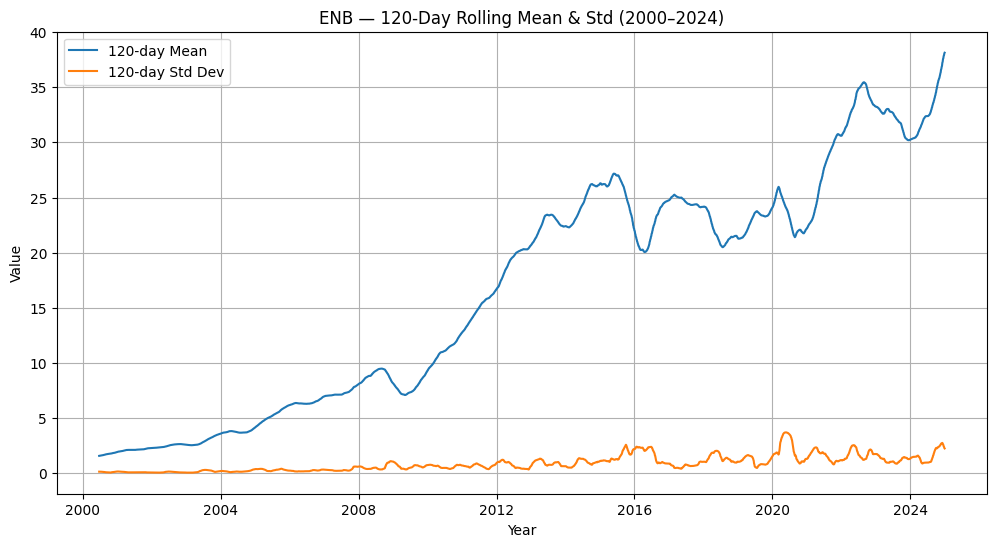

In [11]:
for ticker in tickers.keys():
    df = hist[hist["Ticker"] == ticker].copy()
    df = df.set_index("date")
    
    df["120d_mean"] = df["adjclose"].rolling(120).mean()
    df["120d_std"] = df["adjclose"].rolling(120).std()

    plt.figure(figsize=(12,6))
    plt.title(f"{ticker} — 120-Day Rolling Mean & Std (2000–2024)")
    plt.plot(df.index, df["120d_mean"], label="120-day Mean")
    plt.plot(df.index, df["120d_std"], label="120-day Std Dev")
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [12]:
representatives = {
    "Banking": "JPM",
    "Healthcare": "JNJ",
    "Entertainment": "DIS",
    "Technology": "AAPL",
    "Energy": "CVX",
}


In [13]:
vol_dict = {}

for sector, ticker in representatives.items():
    df = hist[hist["Ticker"] == ticker].copy()
    df = df.set_index("date").sort_index()
    
    df[f"{sector}_vol"] = df["Return"].rolling(120).std()
    vol_dict[sector] = df[f"{sector}_vol"]


In [14]:
vol_df = pd.concat(vol_dict, axis=1)

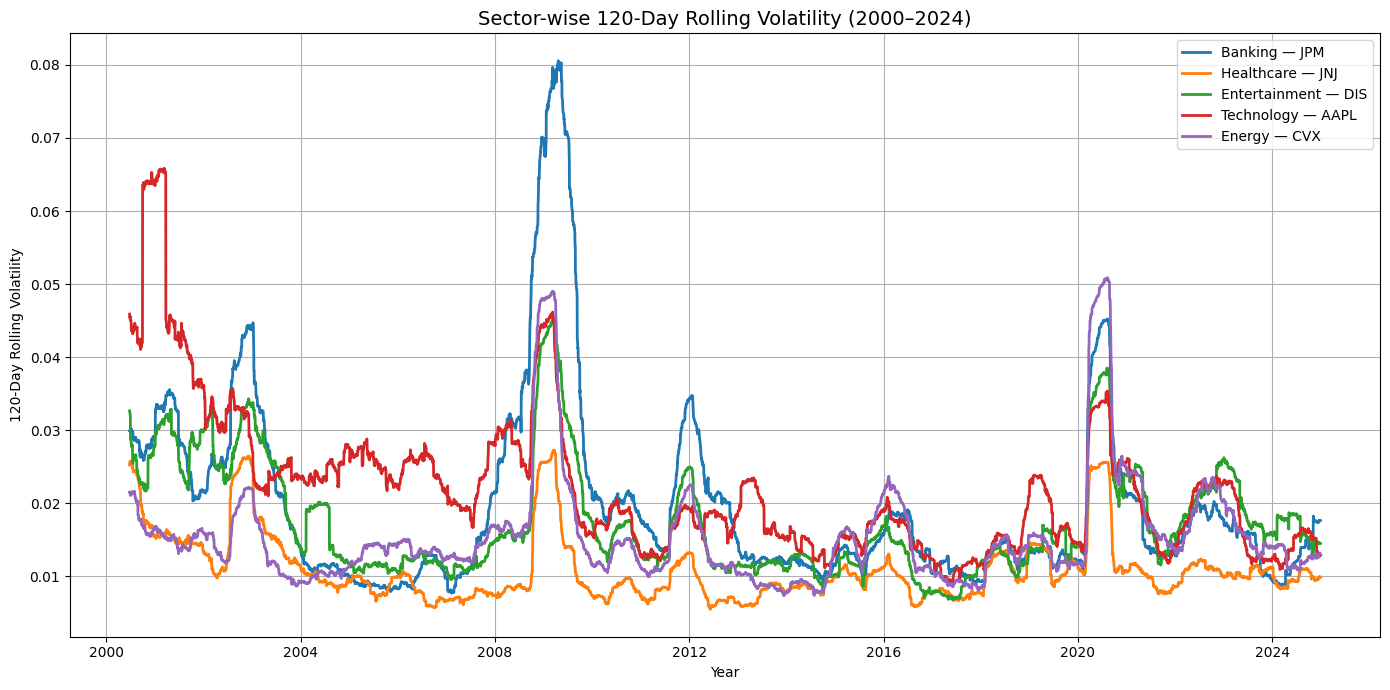

In [15]:
plt.figure(figsize=(14, 7))

for sector, ticker in representatives.items():
    plt.plot(
        vol_df.index,
        vol_df[sector],
        label=f"{sector} — {ticker}",
        linewidth=2
    )

plt.title("Sector-wise 120-Day Rolling Volatility (2000–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("120-Day Rolling Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()